In [ ]:
#!pip install stable-baselines3[extra]
#!pip install backtesting
#!pip install backtesting numpy pandas scikit-learn matplotlib talib torch stable-baselines3 gym xgboost


In [28]:
# =============================================================================
# IMPORTS
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For RL implementation
import gym
from gym import spaces
from stable_baselines3 import PPO, A2C

# Backtesting library
from backtesting import Backtest, Strategy



In [29]:
# =============================================================================
# DATA PREPROCESSING CLASSES
# =============================================================================

class IQRCarryForwardOutlierRemover(BaseEstimator, TransformerMixin):
    """
    Replaces outliers (by IQR rule) with the previous correct value.
    Classic IQR filtering method (InterQuartile Range)
    """
    def __init__(self, factor=1.5, date_col='date', columns=None, sort_by_date=True):
        self.factor = float(factor)
        self.date_col = date_col
        self.columns = columns
        self.sort_by_date = sort_by_date

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expected pandas.DataFrame as input.")
        df = X.copy()

        # auto-select columns: all numeric except date
        if self.columns is None:
            numeric_cols = df.select_dtypes(include=[np.number, "float", "int"]).columns.tolist()
            self.columns_ = [c for c in numeric_cols if c != self.date_col]
        else:
            self.columns_ = list(self.columns)

        # calculate bounds for each column
        self.bounds_ = {}
        for col in self.columns_:
            s = pd.to_numeric(df[col], errors="coerce")
            q1 = np.nanpercentile(s, 25)
            q3 = np.nanpercentile(s, 75)
            iqr = q3 - q1
            lower = q1 - self.factor * iqr
            upper = q3 + self.factor * iqr
            self.bounds_[col] = (lower, upper)

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expected pandas.DataFrame as input.")
        if not hasattr(self, "bounds_"):
            raise RuntimeError("Call fit() first.")

        df = X.copy()

        # sort by date if needed
        if self.sort_by_date and self.date_col in df.columns:
            df = df.sort_values(self.date_col).reset_index(drop=True)

        for col in self.columns_:
            s = pd.to_numeric(df[col], errors="coerce")
            lower, upper = self.bounds_[col]
            is_outlier = (s < lower) | (s > upper)

            # outliers -> NaN, then forward fill
            s_masked = s.mask(is_outlier)
            s_filled = s_masked.ffill()

            # if outliers at beginning - keep original
            leading = s_filled.isna()
            if leading.any():
                s_filled[leading] = s[leading]

            df[col] = s_filled

        return df


In [30]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

def calculate_rsi(new_data: pd.DataFrame, column='close', window=14)->pd.Series:
    """Calculate RSI indicator"""
    delta = new_data[column].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    rsi.fillna(0, inplace=True)
    return rsi

def calculate_moving_rsi(rsi: pd.Series, window=14):
    """Calculate moving average of RSI"""
    return rsi.rolling(window=window, min_periods=1).mean()

class TechIndicatorsTransformer(BaseEstimator, TransformerMixin):
    """Adds technical indicators"""
    def __init__(
        self,
        price_col="close",
        rsi_window=14,
        rsi_ma_window=14,
        sma_short=20,
        sma_long=50,
        date_col="date",
        sort_by_date=True,
        const_margin=0.001
    ):
        self.price_col = price_col
        self.rsi_window = rsi_window
        self.rsi_ma_window = rsi_ma_window
        self.sma_short = sma_short
        self.sma_long = sma_long
        self.date_col = date_col
        self.sort_by_date = sort_by_date
        self.const_margin = const_margin

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("TechnicalIndicatorsTransformer expects pandas.DataFrame")

        df = X.copy()

        # sort by date
        if self.sort_by_date and self.date_col in df.columns:
            df = df.sort_values(self.date_col).reset_index(drop=True)

        price = df[self.price_col].astype(float).values

        # RSI
        rsi = calculate_rsi(df, column=self.price_col, window=self.rsi_window)
        df[f"RSI_{self.rsi_window}"] = rsi
        df[f"RSI_{self.rsi_window}_MA{self.rsi_ma_window}"] = calculate_moving_rsi(
            rsi, window=self.rsi_ma_window
        )

        # MACD
        macd, macd_signal, macd_hist = talib.MACD(
            price, fastperiod=12, slowperiod=26, signalperiod=9
        )
        df["MACD"] = macd
        df["MACD_Signal"] = macd_signal
        df["MACD_Hist"] = macd_hist
        
        # TEMA
        df['TEMA'] = talib.TEMA(df['close'], timeperiod=24)

        # SMA
        df[f"SMA_{self.sma_short}"] = talib.SMA(price, timeperiod=self.sma_short)
        df[f"SMA_{self.sma_long}"] = talib.SMA(price, timeperiod=self.sma_long)

        # Additional indicators
        bb_upper, bb_middle, bb_lower = talib.BBANDS(price, timeperiod=20, nbdevup=2, nbdevdn=2)
        df['BB_Upper'] = bb_upper
        df['BB_Middle'] = bb_middle
        df['BB_Lower'] = bb_lower
        
        df['STOCH_K'], df['STOCH_D'] = talib.STOCH(
            df['high'].values, df['low'].values, price
        )
        
        df['WILLR'] = talib.WILLR(
            df['high'].values, df['low'].values, price, timeperiod=14
        )
        
        df['ATR'] = talib.ATR(df['high'].values, df['low'].values, price, timeperiod=14)
        df['CCI'] = talib.CCI(df['high'].values, df['low'].values, price, timeperiod=14)

        df.fillna(0, inplace=True)
        
        return df

class TargetTransformer(BaseEstimator, TransformerMixin):
    """Create target variable based on future price movement"""
    def __init__(
        self,
        price_col="close",
        date_col="date",
        const_margin=0.001,
        sort_by_date=True,
    ):
        self.price_col = price_col
        self.date_col = date_col
        self.const_margin = const_margin
        self.sort_by_date = sort_by_date
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("TargetTransformer expects pandas.DataFrame")

        df = X.copy()

        if self.sort_by_date and self.date_col in df.columns:
            df = df.sort_values(self.date_col).reset_index(drop=True)

        # build target
        nxt = df['close'].shift(-1)
        diff = nxt - df['close']
        y = np.where(diff >  self.const_margin,  1,
            np.where(diff < -self.const_margin, -1, 0))
        df['target'] = y
        
        return df


In [31]:
# =============================================================================
# RULE-BASED CLASSIFIER
# =============================================================================

def _ema(s: pd.Series, period: int) -> pd.Series:
    return pd.Series(s, index=s.index, dtype=float).ewm(span=period, adjust=False).mean()

def _tema(close: pd.Series, period: int) -> pd.Series:
    ema1 = _ema(close, period)
    ema2 = _ema(ema1, period)
    ema3 = _ema(ema2, period)
    return 3*ema1 - 3*ema2 + ema3

def _macd_from_close(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = _ema(close, fast)
    ema_slow = _ema(close, slow)
    macd = ema_fast - ema_slow
    macd_signal = _ema(macd, signal)
    return macd, macd_signal

class RuleSignalClassifier(BaseEstimator, ClassifierMixin):
    """Rule-based classifier using MACD and TEMA"""
    
    def __init__(self,
                 close_col="close",
                 macd_col="MACD",
                 macd_signal_col="MACD_Signal",
                 tema_col="TEMA",
                 compute_if_missing=True,
                 macd_fast=12, macd_slow=26, macd_signal=9,
                 tema_period=30,
                 neutral_class=0):
        self.close_col = close_col
        self.macd_col = macd_col
        self.macd_signal_col = macd_signal_col
        self.tema_col = tema_col
        self.compute_if_missing = compute_if_missing
        self.macd_fast = macd_fast
        self.macd_slow = macd_slow
        self.macd_signal = macd_signal
        self.tema_period = tema_period
        self.neutral_class = neutral_class

    def fit(self, X: pd.DataFrame, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expected pandas.DataFrame")
        self.classes_ = np.array([-1, self.neutral_class, 1], dtype=int)
        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        df = self._ensure_indicators(X)
        macd = pd.to_numeric(df[self.macd_col], errors="coerce")
        macd_signal = pd.to_numeric(df[self.macd_signal_col], errors="coerce")
        close = pd.to_numeric(df[self.close_col], errors="coerce")
        tema = pd.to_numeric(df[self.tema_col], errors="coerce")

        # trading rules
        buy = (macd > macd_signal) & (close > tema)
        sell = (macd < macd_signal) & (close < tema)

        out = np.full(len(df), self.neutral_class, dtype=int)
        out[sell.fillna(False).values] = -1
        out[buy.fillna(False).values] = 1
        return out

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        y = self.predict(X)
        proba = np.zeros((len(y), 3), dtype=float)
        for i, label in enumerate(y):
            if label == -1:
                proba[i, 0] = 1.0
            elif label == 1:
                proba[i, 2] = 1.0
            else:
                proba[i, 1] = 1.0
        return proba

    def _ensure_indicators(self, X: pd.DataFrame) -> pd.DataFrame:
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Expected pandas.DataFrame")
        if self.close_col not in X.columns:
            raise KeyError(f"Column '{self.close_col}' not found")

        df = X.copy()

        # MACD
        need_macd = (self.macd_col not in df.columns) or (self.macd_signal_col not in df.columns)
        if need_macd:
            if not self.compute_if_missing:
                missing = [c for c in [self.macd_col, self.macd_signal_col] if c not in df.columns]
                raise KeyError(f"Missing {missing}")
            macd, macd_sig = _macd_from_close(
                df[self.close_col].astype(float),
                fast=self.macd_fast, slow=self.macd_slow, signal=self.macd_signal
            )
            df[self.macd_col] = macd
            df[self.macd_signal_col] = macd_sig

        # TEMA
        if self.tema_col not in df.columns:
            if not self.compute_if_missing:
                raise KeyError(f"Missing '{self.tema_col}'")
            df[self.tema_col] = _tema(df[self.close_col].astype(float), self.tema_period)

        return df


In [32]:
# =============================================================================
# NEURAL NETWORK CLASSIFIER
# =============================================================================

class TradingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values if isinstance(X, pd.DataFrame) else X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TradingNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=3, dropout=0.3):
        super(TradingNN, self).__init__()
        layers = []
        
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_dims=[128, 64, 32], num_classes=3, epochs=50, 
                 batch_size=64, learning_rate=0.001, dropout=0.3):
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.classes_ = np.array([-1, 0, 1])
        
    def fit(self, X, y):
        # Convert labels to 0, 1, 2
        label_map = {-1: 0, 0: 1, 1: 2}
        y_mapped = np.array([label_map[label] for label in y])
        
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Initialize model
        input_dim = X_scaled.shape[1]
        self.model = TradingNN(input_dim, self.hidden_dims, self.num_classes, self.dropout)
        
        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        dataset = TradingDataset(X_scaled, y_mapped)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {total_loss/len(dataloader):.4f}')
        
        return self
    
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_scaled)
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            
        # Convert back to original labels
        label_map_reverse = {0: -1, 1: 0, 2: 1}
        return np.array([label_map_reverse[pred.item()] for pred in predicted])
    
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_scaled)
            outputs = self.model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            
        return probabilities.numpy()


In [33]:
# =============================================================================
# TRADING ENVIRONMENT FOR RL
# =============================================================================

class TradingEnvironment(gym.Env):
    """Custom Environment for Trading with RL"""
    
    def __init__(self, data, initial_balance=10000, transaction_cost=0.001):
        super(TradingEnvironment, self).__init__()
        
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        
        # Action space: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space
        self.n_features = len([col for col in data.columns if col not in ['date', 'target']])
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.n_features + 3,), dtype=np.float32
        )
        
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        
        return self._get_observation()
    
    def _get_observation(self):
        if self.current_step >= len(self.data):
            return np.zeros(self.observation_space.shape[0])
            
        # Get technical indicators
        features = []
        for col in self.data.columns:
            if col not in ['date', 'target']:
                features.append(self.data.iloc[self.current_step][col])
        
        # Add portfolio state
        current_price = self.data.iloc[self.current_step]['close']
        portfolio_state = [
            self.balance / self.initial_balance,
            self.shares_held * current_price / self.initial_balance,
            self.net_worth / self.initial_balance
        ]
        
        obs = np.array(features + portfolio_state, dtype=np.float32)
        return obs
    
    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            return self._get_observation(), 0, True, {}
            
        current_price = self.data.iloc[self.current_step]['close']
        
        # Execute action
        if action == 1:  # Buy
            shares_to_buy = self.balance / current_price * (1 - self.transaction_cost)
            self.shares_held += shares_to_buy
            self.balance = 0
        elif action == 2:  # Sell
            self.balance += self.shares_held * current_price * (1 - self.transaction_cost)
            self.shares_held = 0
        
        self.current_step += 1
        
        # Calculate reward
        new_price = self.data.iloc[self.current_step]['close']
        self.net_worth = self.balance + self.shares_held * new_price
        
        reward = (self.net_worth - self.max_net_worth) / self.initial_balance
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
        
        done = self.current_step >= len(self.data) - 1
        
        return self._get_observation(), reward, done, {}


In [34]:
# =============================================================================
# ENSEMBLE RL AGENT
# =============================================================================

class EnsembleRLAgent:
    """Ensemble agent that combines multiple models with RL on top"""
    
    def __init__(self, base_models, rl_model_type='PPO'):
        self.base_models = base_models
        self.rl_model_type = rl_model_type
        self.rl_model = None
        self.is_fitted = False
        
    def _get_ensemble_features(self, X):
        """Get predictions from all base models as features for RL"""
        ensemble_features = []
        
        for name, model in self.base_models.items():
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(X)
                ensemble_features.append(proba)
            else:
                pred = model.predict(X).reshape(-1, 1)
                ensemble_features.append(pred)
        
        return np.hstack(ensemble_features)
    
    def fit(self, X, y, env_data, total_timesteps=10000):
        """Train the ensemble and then the RL agent"""
        print("Training base models...")
        
        # Train all base models
        for name, model in self.base_models.items():
            print(f"Training {name}...")
            model.fit(X, y)
        
        print("Training RL agent...")
        
        # Create environment with ensemble predictions
        ensemble_preds = self._get_ensemble_features(X)
        
        # Combine with original features for RL environment
        rl_env_data = env_data.copy()
        for i in range(ensemble_preds.shape[1]):
            rl_env_data[f'ensemble_feature_{i}'] = ensemble_preds[:, i]
        
        # Create and train RL model
        env = TradingEnvironment(rl_env_data)
        
        if self.rl_model_type == 'PPO':
            self.rl_model = PPO('MlpPolicy', env, verbose=1)
        elif self.rl_model_type == 'A2C':
            self.rl_model = A2C('MlpPolicy', env, verbose=1)
        
        self.rl_model.learn(total_timesteps=total_timesteps)
        self.is_fitted = True
        
        return self
    
    def predict(self, X, env_data):
        """Make predictions using the trained ensemble + RL"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        # Get ensemble features
        ensemble_preds = self._get_ensemble_features(X)
        
        # Combine with original features
        rl_env_data = env_data.copy()
        for i in range(ensemble_preds.shape[1]):
            rl_env_data[f'ensemble_feature_{i}'] = ensemble_preds[:, i]
        
        # Create environment for prediction
        env = TradingEnvironment(rl_env_data)
        
        # Get RL predictions
        obs = env.reset()
        actions = []
        
        for _ in range(len(X)):
            action, _ = self.rl_model.predict(obs, deterministic=True)
            actions.append(action)
            obs, _, done, _ = env.step(action)
            if done:
                break
        
        # Convert actions to trading signals
        action_to_signal = {0: 0, 1: 1, 2: -1}
        signals = [action_to_signal[action] for action in actions]
        
        return np.array(signals[:len(X)])


In [35]:
# =============================================================================
# BACKTESTING WITH BACKTESTING LIBRARY
# =============================================================================

class SignalLongShort(Strategy):
    """Strategy following pre-calculated signals {-1,0,1}"""
    signals: pd.Series = None
    frac = 0.99

    def init(self):
        s = self.signals.reindex(self.data.index).fillna(0).astype(int)
        self.sig = self.I(lambda: s.values)

    def next(self):
        price = float(self.data.Close[-1])
        if not np.isfinite(price) or price <= 0:
            return

        sig = int(self.sig[-1])
        prev = int(self.sig[-2]) if len(self.sig) > 1 else None
        if prev == sig:
            return

        if self.position:
            self.position.close()

        if sig == 1:
            self.buy(size=self.frac)
        elif sig == -1:
            self.sell(size=self.frac)

class BuyHold(Strategy):
    """Buy and Hold benchmark strategy"""
    frac = 0.99
    def init(self):
        pass
    
    def next(self):
        if not self.position:
            self.buy(size=self.frac)


In [36]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def create_sample_data():
    """Create sample data for demonstration"""
    np.random.seed(42)
    n_samples = 1000
    
    dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')
    
    # Generate realistic price data
    base_price = 100
    trend = np.linspace(0, 20, n_samples)
    noise = np.random.normal(0, 2, n_samples)
    random_walk = np.cumsum(np.random.normal(0, 1, n_samples))
    
    close_prices = base_price + trend + noise + random_walk
    
    # Generate OHLV data
    highs = close_prices + np.abs(np.random.normal(0, 1, n_samples))
    lows = close_prices - np.abs(np.random.normal(0, 1, n_samples))
    opens = np.roll(close_prices, 1)
    opens[0] = close_prices[0]
    volumes = np.random.uniform(1000000, 5000000, n_samples)
    
    # Create USD_RUB rate
    usd_rub = np.random.uniform(70, 80, n_samples)
    
    df = pd.DataFrame({
        'date': dates,
        'close': close_prices,
        'open': opens,
        'high': highs,
        'low': lows,
        'volume': volumes,
        'USD_RUB': usd_rub,
        'close_RUR': close_prices * usd_rub
    })
    
    return df

def evaluate_models(X_train, y_train, X_test, y_test, base_models, ensemble_agent, test_data):
    """Evaluate all models and compare performance"""
    
    print("="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    
    results = {}
    
    # Evaluate individual base models
    print("\n1. BASE MODEL PERFORMANCE:")
    print("-" * 40)
    
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"{name} Accuracy: {accuracy:.4f}")
            
            results[name] = {
                'accuracy': accuracy,
                'predictions': y_pred
            }
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            results[name] = {'accuracy': 0, 'predictions': np.zeros(len(y_test))}
    
    # Evaluate ensemble
    print("\n2. ENSEMBLE MODEL PERFORMANCE:")
    print("-" * 40)
    
    try:
        # Traditional voting ensemble
        voting_models = [(name, model) for name, model in base_models.items() 
                        if name != 'neural_net']
        
        if len(voting_models) > 1:
            voting_ensemble = VotingClassifier(
                estimators=voting_models,
                voting='hard'
            )
            voting_ensemble.fit(X_train, y_train)
            ensemble_pred = voting_ensemble.predict(X_test)
            ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
            
            print(f"Voting Ensemble Accuracy: {ensemble_accuracy:.4f}")
            results['voting_ensemble'] = {
                'accuracy': ensemble_accuracy,
                'predictions': ensemble_pred
            }
    
    except Exception as e:
        print(f"Error with voting ensemble: {str(e)}")
    
    # Evaluate RL-enhanced ensemble (if provided)
    if ensemble_agent is not None:
        print("\n3. RL-ENHANCED ENSEMBLE:")
        print("-" * 40)
        
        try:
            print("Training RL-enhanced ensemble...")
            ensemble_agent.fit(X_train, y_train, test_data.iloc[:len(X_train)], total_timesteps=5000)
            
            rl_predictions = ensemble_agent.predict(X_test, test_data.iloc[len(X_train):len(X_train)+len(X_test)])
            rl_accuracy = accuracy_score(y_test, rl_predictions)
            
            print(f"RL-Enhanced Ensemble Accuracy: {rl_accuracy:.4f}")
            results['rl_ensemble'] = {
                'accuracy': rl_accuracy,
                'predictions': rl_predictions
            }
            
        except Exception as e:
            print(f"Error with RL ensemble: {str(e)}")
            results['rl_ensemble'] = {'accuracy': 0, 'predictions': np.zeros(len(y_test))}
    
    # Summary
    print("\n4. PERFORMANCE SUMMARY:")
    print("-" * 40)
    print(f"{'Model':<20} {'Accuracy':<10}")
    print("-" * 30)
    
    for name, result in results.items():
        print(f"{name:<20} {result['accuracy']:<10.4f}")
    
    return results

def run_backtest_comparison(test_data, results):
    """Run backtesting comparison between different strategies"""
    
    print("\n" + "="*60)
    print("BACKTESTING RESULTS")
    print("="*60)
    
    # Prepare data for backtesting
    backtest_data = pd.DataFrame({
        'Open': test_data['open'].astype(float),
        'High': test_data['high'].astype(float),
        'Low': test_data['low'].astype(float),
        'Close': test_data['close'].astype(float),
        'Volume': test_data['volume'].fillna(0).astype(float),
    })
    
    backtest_results = {}
    
    # Buy & Hold benchmark
    print("\nRunning Buy & Hold benchmark...")
    bt_bh = Backtest(
        backtest_data, BuyHold,
        cash=100_000,
        commission=0.0005,
        exclusive_orders=True,
        trade_on_close=False
    )
    stats_bh = bt_bh.run()
    backtest_results['buy_hold'] = stats_bh
    
    # Test signal strategies
    for model_name, result in results.items():
        if 'predictions' in result:
            print(f"Running backtest for {model_name}...")
            
            try:
                signals = pd.Series(result['predictions'], index=backtest_data.index)
                
                # Create strategy class with signals
                class ModelStrategy(SignalLongShort):
                    pass
                
                ModelStrategy.signals = signals
                
                bt_model = Backtest(
                    backtest_data, ModelStrategy,
                    cash=100_000,
                    commission=0.0005,
                    exclusive_orders=True,
                    trade_on_close=False,
                    margin=1.0
                )
                
                stats_model = bt_model.run()
                backtest_results[model_name] = stats_model
                
            except Exception as e:
                print(f"Error backtesting {model_name}: {str(e)}")
    
    # Print comparison
    print("\nBACKTEST PERFORMANCE COMPARISON:")
    print("-" * 70)
    print(f"{'Strategy':<20} {'Return %':<12} {'Max DD %':<12} {'Sharpe':<8} {'Trades':<8}")
    print("-" * 70)
    
    for name, stats in backtest_results.items():
        return_pct = stats['Return [%]'] if 'Return [%]' in stats else 0
        max_dd = stats['Max. Drawdown [%]'] if 'Max. Drawdown [%]' in stats else 0
        sharpe = stats['Sharpe Ratio'] if 'Sharpe Ratio' in stats else 0
        trades = stats['# Trades'] if '# Trades' in stats else 0
        
        print(f"{name:<20} {return_pct:<12.2f} {max_dd:<12.2f} {sharpe:<8.2f} {trades:<8}")
    
    return backtest_results

def plot_backtest_results(backtest_results):
    """Plot portfolio performance comparison"""
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Equity curves
    plt.subplot(2, 2, 1)
    for name, stats in backtest_results.items():
        if hasattr(stats, '_equity_curve') and stats._equity_curve is not None:
            equity = stats._equity_curve['Equity']
            plt.plot(equity.index, equity.values, label=f"{name} ({stats['Return [%]']:.1f}%)")
    
    plt.title('Equity Curves Comparison')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Returns comparison
    plt.subplot(2, 2, 2)
    strategies = list(backtest_results.keys())
    returns = [backtest_results[s]['Return [%]'] if 'Return [%]' in backtest_results[s] else 0 
               for s in strategies]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))
    plt.bar(strategies, returns, color=colors)
    plt.title('Total Returns Comparison')
    plt.ylabel('Return (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Drawdown comparison
    plt.subplot(2, 2, 3)
    drawdowns = [abs(backtest_results[s]['Max. Drawdown [%]']) if 'Max. Drawdown [%]' in backtest_results[s] else 0 
                 for s in strategies]
    
    plt.bar(strategies, drawdowns, color=colors)
    plt.title('Maximum Drawdown Comparison')
    plt.ylabel('Max Drawdown (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Risk-return scatter
    plt.subplot(2, 2, 4)
    sharpe_ratios = [backtest_results[s]['Sharpe Ratio'] if 'Sharpe Ratio' in backtest_results[s] else 0 
                     for s in strategies]
    
    plt.scatter(drawdowns, returns, c=colors, s=100, alpha=0.7)
    for i, strategy in enumerate(strategies):
        plt.annotate(strategy, (drawdowns[i], returns[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.title('Risk vs Return')
    plt.xlabel('Max Drawdown (%)')
    plt.ylabel('Return (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_complete_demo():
    """Run a complete demonstration with sample data"""
    print("Financial Ensemble RL Trading System - Complete Demo")
    print("="*60)
    
    # Create sample data
    print("1. Creating sample data...")
    sample_data = create_sample_data()
    print(f"   Generated {len(sample_data)} data points")
    
    # Set up pipeline
    print("\n2. Setting up data processing pipeline...")
    pipe_transform = Pipeline([
        ("iqr_cf", IQRCarryForwardOutlierRemover(
            factor=1.5,
            date_col='date',
            columns=['close','open','high','low','volume','USD_RUB','close_RUR'],
            sort_by_date=True
        )),
        ("ti", TechIndicatorsTransformer(
            price_col="close",
            rsi_window=14,
            rsi_ma_window=14,
            sma_short=20,
            sma_long=50,
        )),
        ('target', TargetTransformer(
            price_col='close',
            date_col='date',
            const_margin=0.02
        ))
    ])
    
    # Process data
    print("3. Processing data...")
    df_processed = pipe_transform.fit_transform(sample_data)
    print(f"   Created {df_processed.shape[1]} features")
    
    # Split data (80/20 split)
    print("\n4. Splitting data...")
    split_idx = int(len(df_processed) * 0.8)
    train = df_processed.iloc[:split_idx]
    test = df_processed.iloc[split_idx:]
    
    # Prepare features and targets
    feature_cols = [col for col in train.columns if col not in ['date', 'target']]
    X_train = train[feature_cols]
    y_train = train['target']
    X_test = test[feature_cols]
    y_test = test['target']
    
    print(f"   Training set: {len(X_train)} samples")
    print(f"   Test set: {len(X_test)} samples")
    print(f"   Features: {len(feature_cols)}")
    
    # Define base models
    base_models = {
        'rule_based': RuleSignalClassifier(
            close_col="close",
            macd_col="MACD",
            macd_signal_col="MACD_Signal",
            tema_col="TEMA",
            compute_if_missing=True,
            neutral_class=0
        ),
        'random_forest': RandomForestClassifier(
            n_estimators=50,
            max_depth=5,
            random_state=42
        ),
        'logistic_regression': LogisticRegression(
            random_state=42,
            max_iter=1000
        ),
        'neural_net': NeuralNetworkClassifier(
            hidden_dims=[64, 32],
            epochs=20,
            batch_size=32
        )
    }
    
    print(f"\n5. Training {len(base_models)} base models...")
    
    # Create ensemble RL agent
    ensemble_agent = EnsembleRLAgent(base_models, rl_model_type='PPO')
    
    # Evaluate models
    results = evaluate_models(X_train, y_train, X_test, y_test, 
                            base_models, ensemble_agent, df_processed)
    
    # Run backtests
    print("\n6. Running backtests...")
    backtest_results = run_backtest_comparison(test, results)
    
    # Plot results
    print("\n7. Plotting results...")
    plot_backtest_results(backtest_results)
    
    return df_processed, results, backtest_results


In [37]:
# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    print("Financial Ensemble RL Trading System")
    print("="*50)
    print("\nTo run the complete demo, execute:")
    print("df_processed, results, backtest_results = run_complete_demo()")
    print("\nFor installation requirements, run:")
    print("!pip install backtesting numpy pandas scikit-learn matplotlib talib torch stable-baselines3 gym xgboost")
    
    # Uncomment the following line to run the demo automatically
    # df_processed, results, backtest_results = run_complete_demo()

Financial Ensemble RL Trading System

To run the complete demo, execute:
df_processed, results, backtest_results = run_complete_demo()

For installation requirements, run:
!pip install backtesting numpy pandas scikit-learn matplotlib talib torch stable-baselines3 gym xgboost


Financial Ensemble RL Trading System - Complete Demo
1. Creating sample data...
   Generated 1000 data points

2. Setting up data processing pipeline...
3. Processing data...
   Created 25 features

4. Splitting data...
   Training set: 800 samples
   Test set: 200 samples
   Features: 23

5. Training 4 base models...
MODEL EVALUATION RESULTS

1. BASE MODEL PERFORMANCE:
----------------------------------------

Training rule_based...
rule_based Accuracy: 0.2100

Training random_forest...
random_forest Accuracy: 0.6600

Training logistic_regression...
logistic_regression Accuracy: 0.7000

Training neural_net...
Epoch 0, Loss: 1.0334
Epoch 10, Loss: 0.6735
neural_net Accuracy: 0.6800

2. ENSEMBLE MODEL PERFORMANCE:
----------------------------------------
Error with voting ensemble: The estimator RuleSignalClassifier should be a classifier.

3. RL-ENHANCED ENSEMBLE:
----------------------------------------
Training RL-enhanced ensemble...
Training base models...
Training rule_based...
Tr

Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]

Running backtest for rule_based...


Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]

Running backtest for random_forest...


Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]

Running backtest for logistic_regression...


Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]

Running backtest for neural_net...


Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]

Running backtest for rl_ensemble...


Backtest.run:   0%|          | 0/199 [00:00<?, ?bar/s]


BACKTEST PERFORMANCE COMPARISON:
----------------------------------------------------------------------
Strategy             Return %     Max DD %     Sharpe   Trades  
----------------------------------------------------------------------
buy_hold             4.27         -7.14        nan      0.0     
rule_based           -71.23       -71.55       nan      70.0    
random_forest        252.13       -3.77        nan      70.0    
logistic_regression  299.33       -3.47        nan      90.0    
neural_net           298.66       -3.48        nan      90.0    
rl_ensemble          0.00         -0.00        nan      0.0     

7. Plotting results...


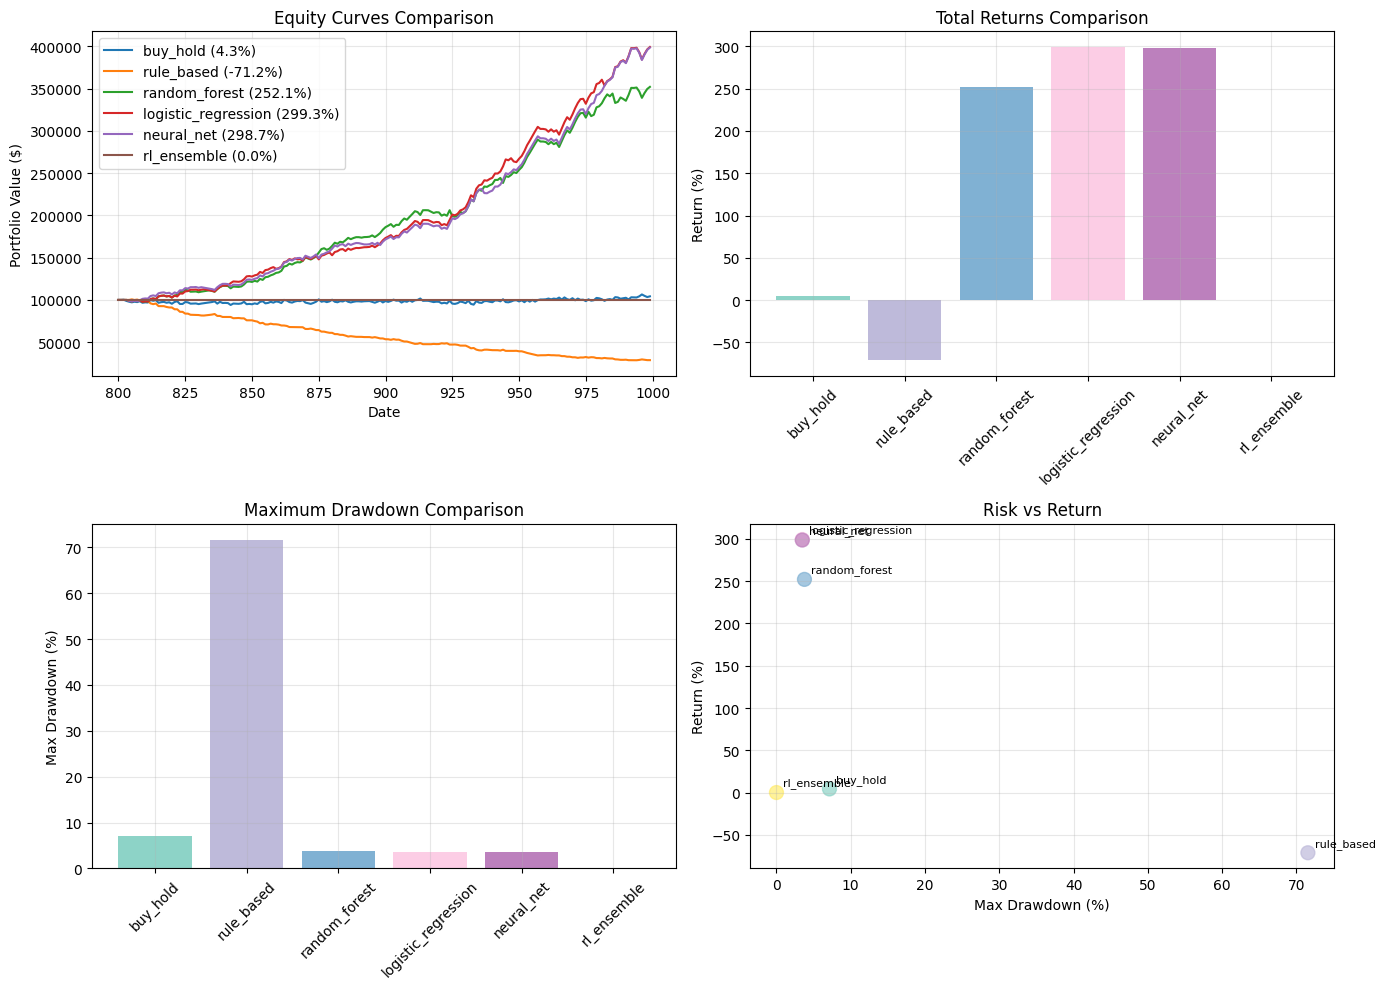

In [39]:
df_processed, results, backtest_results = run_complete_demo()
